Background error: HTTP Error 403: Forbidden

Logistic Regression Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       198
         1.0       0.33      1.00      0.50         2

    accuracy                           0.98       200
   macro avg       0.67      0.99      0.74       200
weighted avg       0.99      0.98      0.98       200

Background error: HTTP Error 403: Forbidden
Background error: HTTP Error 403: Forbidden

Random Forest Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       198
         1.0       1.00      1.00      1.00         2

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Background error: HTTP Error 403: Forbidden
Background error: HTTP Error 403: Forbidden

XGBoost Report:
              precision    recall  f1-score   support

  

d:\Users\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\envs\tf_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Background error: HTTP Error 403: Forbidden

All plots saved successfully!


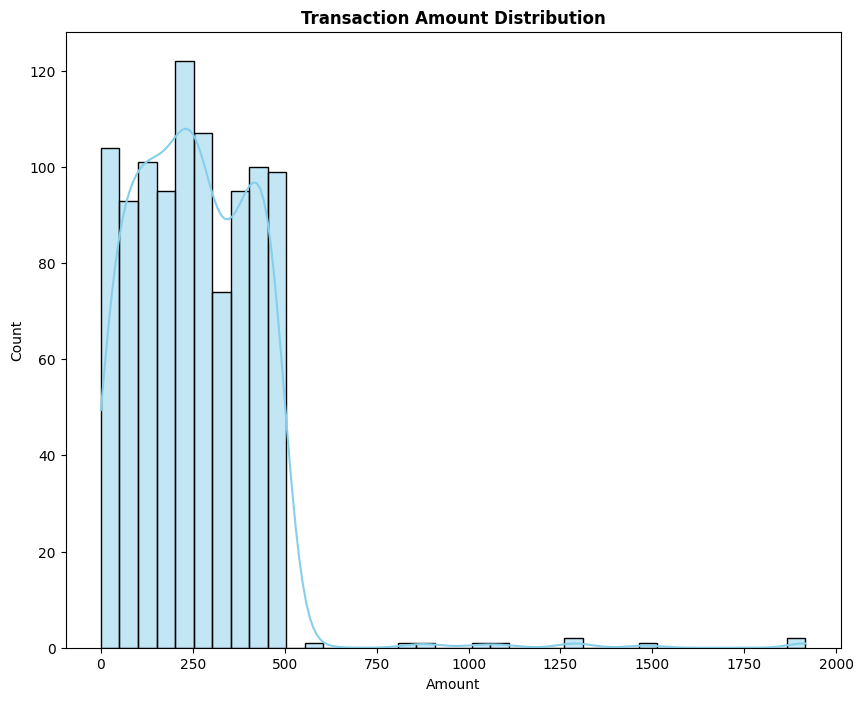

In [3]:
# fraud_detection.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
import xgboost as xgb
import ssl

# Bypass SSL verification (for background image)
ssl._create_default_https_context = ssl._create_unverified_context

# Background image configuration
BACKGROUND_IMAGE_URL = "https://img.freepik.com/premium-vector/hacker-binary-code-background_154942106.jpg"

def add_background(ax):
    """Add background image to plot"""
    try:
        img = mpimg.imread(urlopen(BACKGROUND_IMAGE_URL))
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        ax.imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=0.2, zorder=-1)
    except Exception as e:
        print(f"Background error: {str(e)}")

def main():
    # Load data - UPDATE PATH TO YOUR CSV FILE
    df = pd.read_csv('credit_card_fraud.csv')
    
    # Preprocessing
    X = df.drop('Class', axis=1)
    y = df['Class']
    scaler = RobustScaler()
    X['Amount'] = scaler.fit_transform(X[['Amount']])
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Define models
    models = {
        "Logistic Regression": LogisticRegression(class_weight={0:1, 1:15}, max_iter=1000),
        "Random Forest": RandomForestClassifier(class_weight={0:1, 1:15}),
        "XGBoost": xgb.XGBClassifier(scale_pos_weight=15),
        "Isolation Forest": IsolationForest(contamination=0.007)
    }
    
    # Plot distributions
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    sns.histplot(df['Amount'], kde=True, color='skyblue')
    plt.title('Transaction Amount Distribution', fontweight='bold')
    add_background(ax)
    plt.savefig('amount_dist.png')
    
    # Train and evaluate models
    for name, model in models.items():
        if name == "Isolation Forest":
            model.fit(X_train)
            y_pred = [1 if x == -1 else 0 for x in model.predict(X_test)]
        else:
            pipeline = make_pipeline(SMOTE(sampling_strategy=0.3), model)
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
        
        print(f"\n{name} Report:")
        print(classification_report(y_test, y_pred))
        
        # Confusion matrix plot
        plt.figure(figsize=(6, 5))
        ax = plt.gca()
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', 
                   xticklabels=['Legit', 'Fraud'], 
                   yticklabels=['Legit', 'Fraud'])
        plt.title(f'{name} Confusion Matrix', fontweight='bold')
        add_background(ax)
        plt.savefig(f'cm_{name.lower().replace(" ", "_")}.png')
        plt.close()
        
        # Precision-Recall curve (skip for Isolation Forest)
        if name != "Isolation Forest":
            y_prob = pipeline.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_prob)
            avg_precision = average_precision_score(y_test, y_prob)
            
            plt.figure(figsize=(8, 6))
            ax = plt.gca()
            plt.plot(recall, precision, lw=2, color='purple')
            plt.title(f'Precision-Recall Curve (AP={avg_precision:.2f})', fontweight='bold')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            add_background(ax)
            plt.savefig(f'pr_{name.lower().replace(" ", "_")}.png')
            plt.close()

    print("\nAll plots saved successfully!")

if __name__ == "__main__":
    main()